# Сборный проект №1

## Описание проекта

В данном проекте мы будем анализировать рынок компьютерных игр по всему миру. Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, /Xbox/ или /PlayStation/).

**Цель**: 
* Выявить закономерности, которые определяют успешность игры.

**Задачи**:
* Обработать данные (пропуски, типы данных, названия)
* Проверить ситуацию на рынке (разницу в продажах в зависимости от консоли, влияние отзывов, распределение игр по жанрам)
* Создать усредненный портрет пользователя в разных регионах (Северная Америка, Европа, Япония)
* Проверить гипотезы о взаимосвязи пользовательских оценок (платформ, жанров)


## Предобработка данных

### Получение данных

In [20]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import missingno as msno

In [21]:
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/games.csv')
except:
    df = pd.read_csv('~/Practicum/games.csv')

In [22]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [24]:
df.size

183865

### Названия столбцов

Приведем названия столбцов к нижнему регистру.

In [25]:
df.columns = df.columns.str.lower()

### Типы данных в столбцах

Необходимо заменить тип данных в трех столбцах.
*   `year_of_release` (точка после запятой здесь ни к чему, меняем на `int`)
*   `critic_score` (здесь только целочисленные значения, поэтому меняем тип на `int`)
*   `user_score` (в столбце есть нечисловое значение; нужно обработать нечисловое значение, а затем заменить тип на `float`, поскольку пользовательский рейтинг содержит дробные части)

In [26]:
df['year_of_release'] = np.floor(pd.to_numeric(df['year_of_release'], errors='coerce')).astype('Int64')

### Пропуски значений

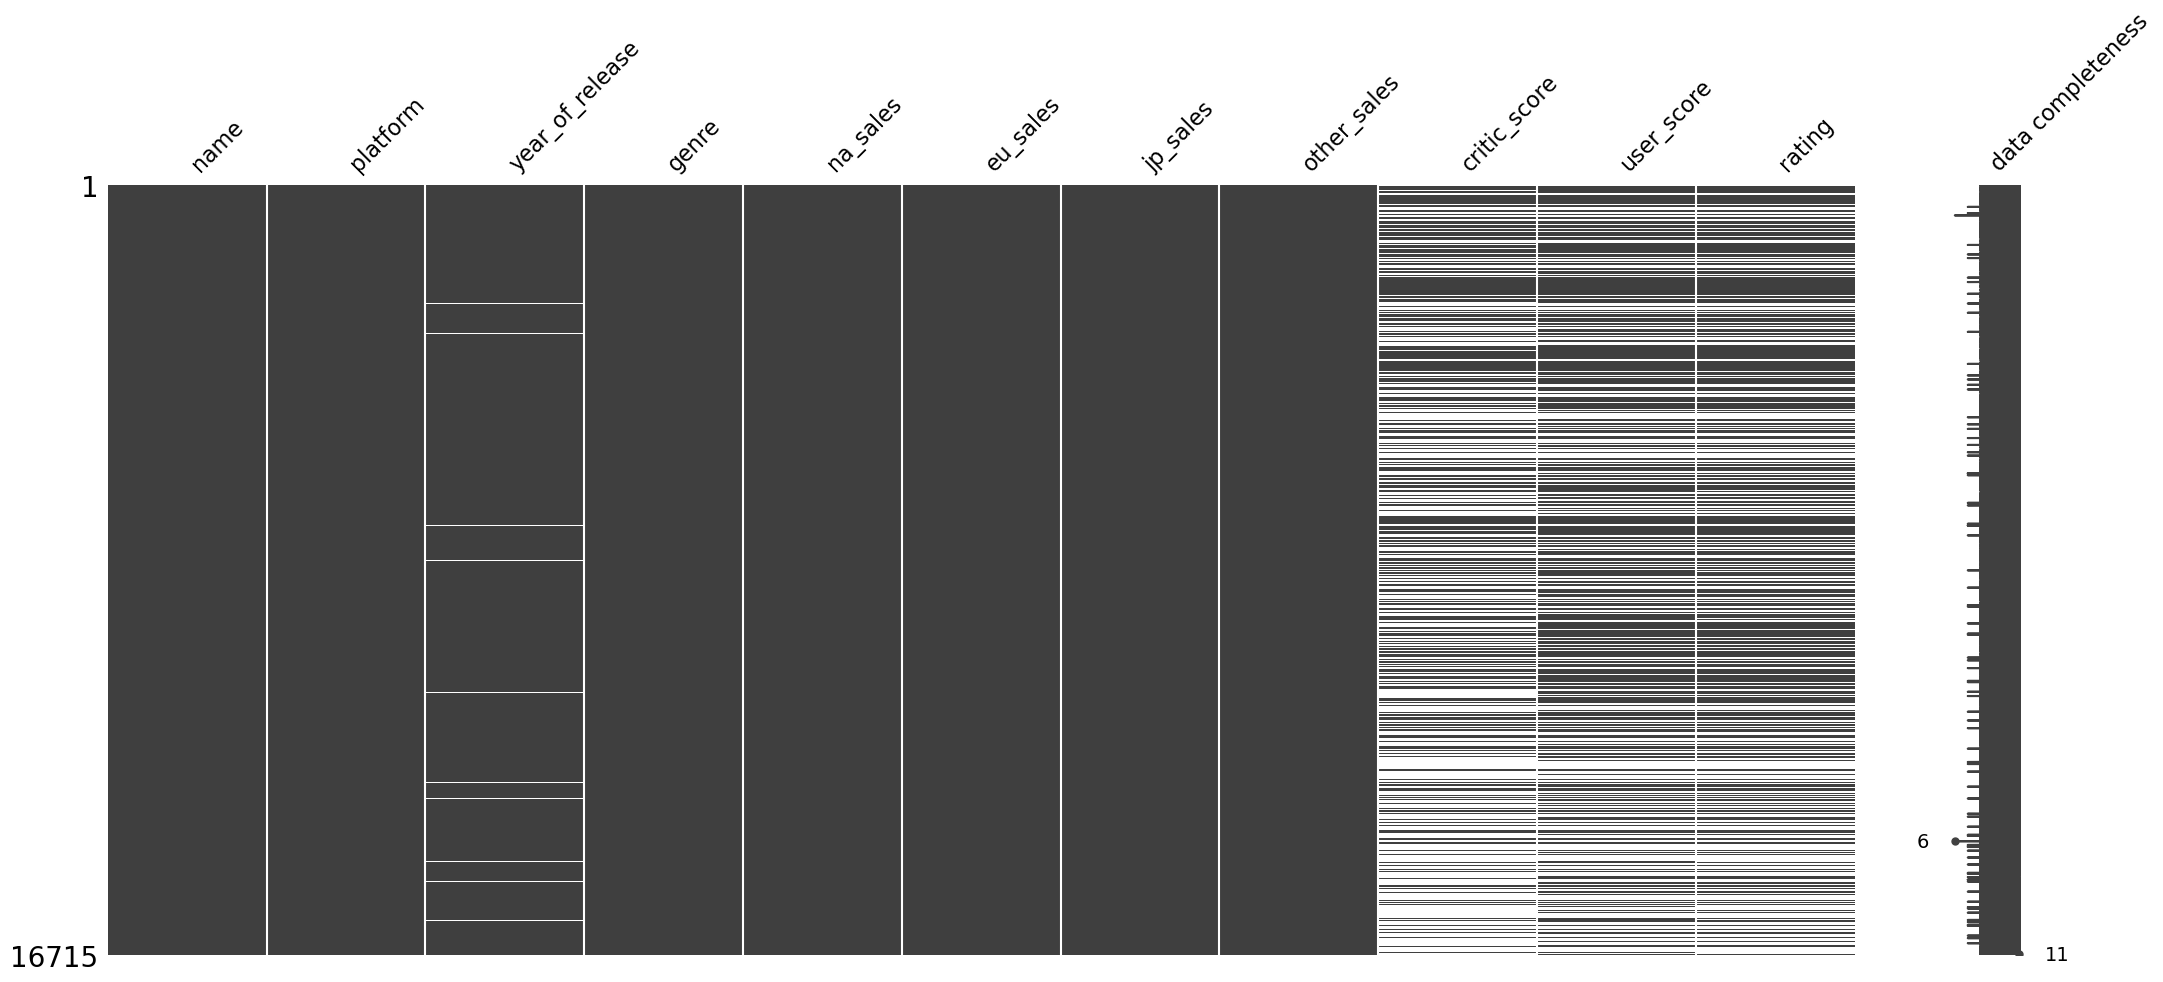

In [32]:
msno.matrix(df, labels=True);

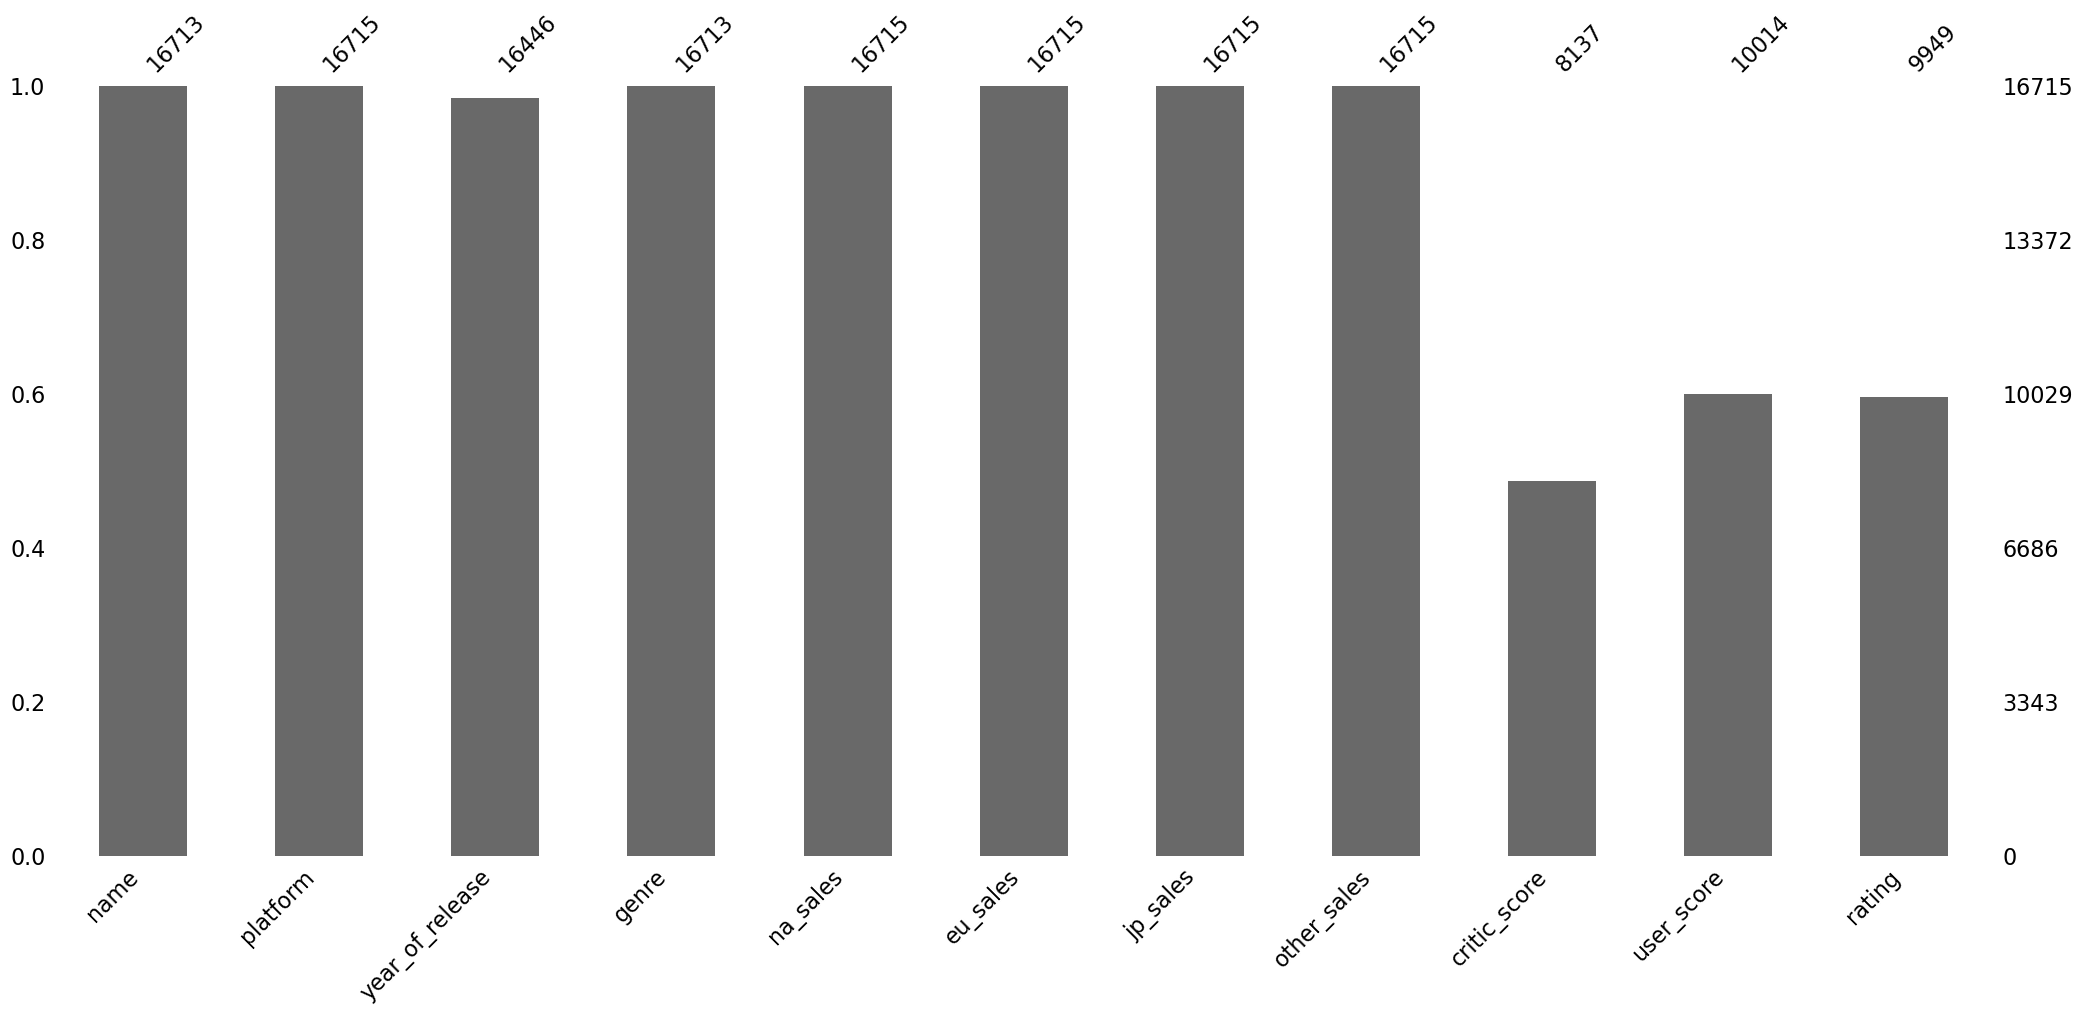

In [33]:
msno.bar(df);

<AxesSubplot:>

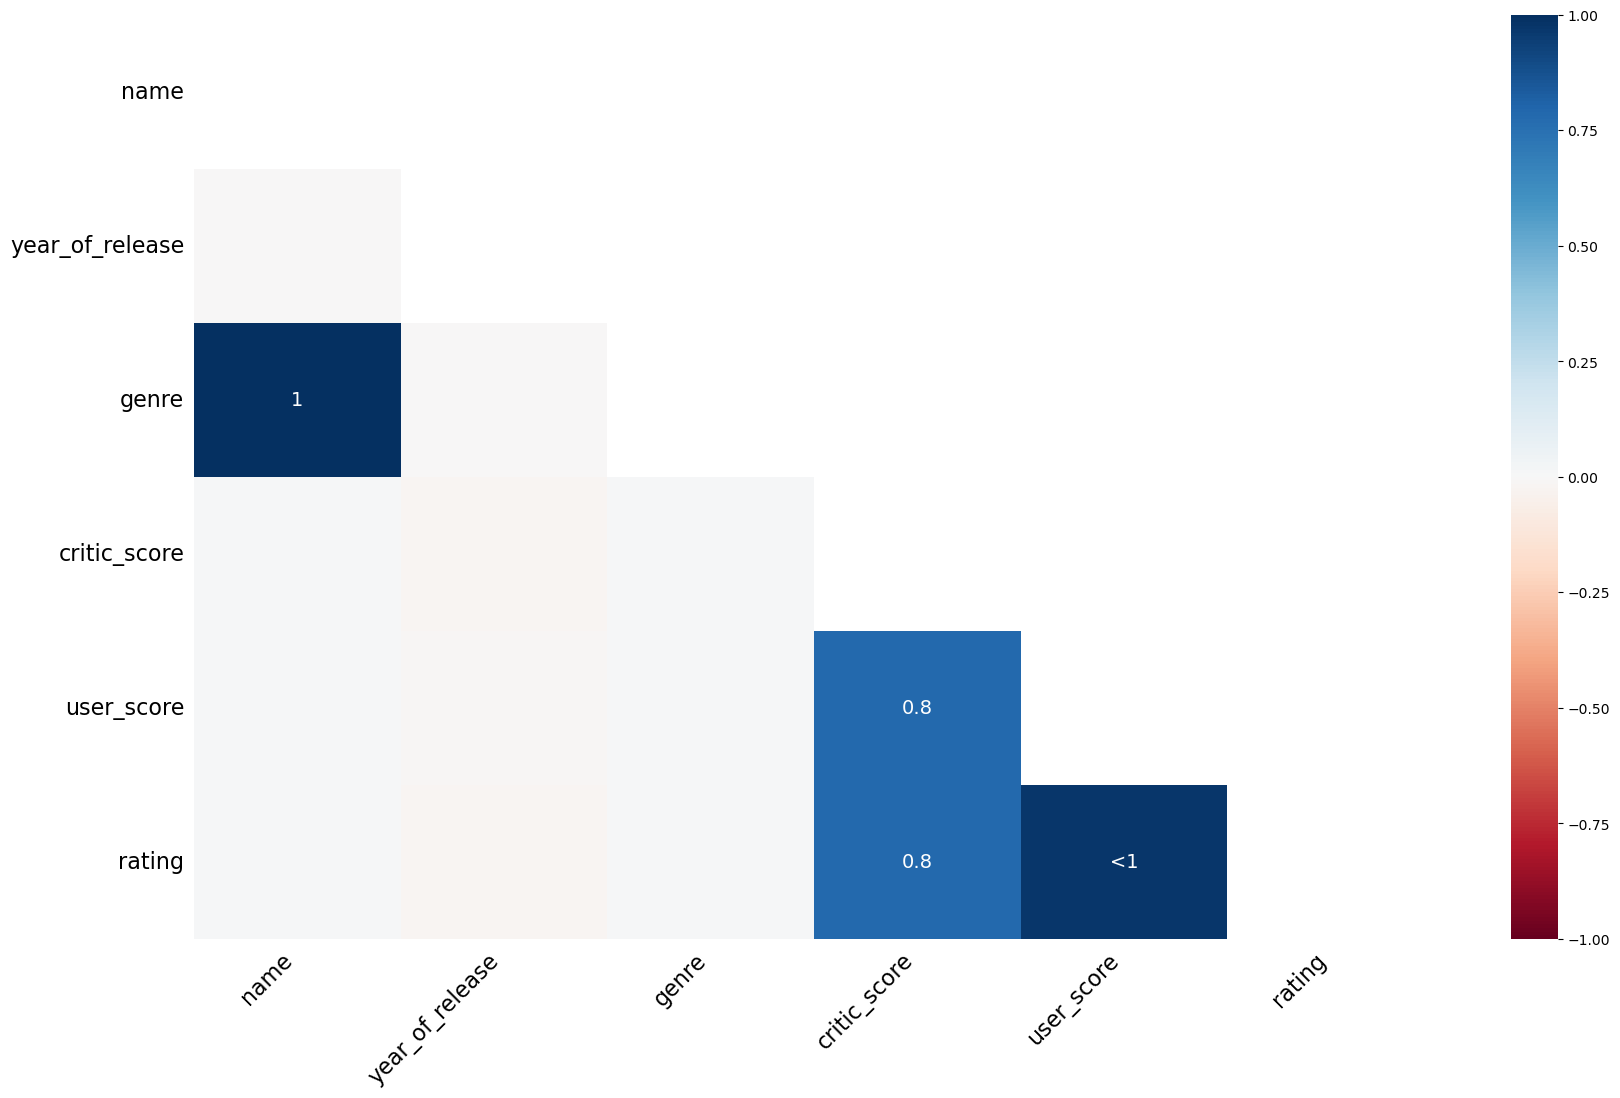

In [34]:
msno.heatmap(df)

Пропущенные значения есть в 6 столбцах. Пропуски из `name` и `genre` слишком незначительны по объему, поэтому их смело отбрасываем. Год восстановить проблематично, хотя некоторые названия игр содержат в себе дату выхода (не факт, что фактическую дату, например, Metro 2033). Значения из столбцов пользовательских и экспертных оценок не поддаются определению. Это количественные данные, которые нельзя взять из головы. Мы также не можем узнать точный рейтинг игры, но, поскольку это не числовое значение, мы заменим пропуски на тип 'unknown'.

Наконец, следует отметить, что в таблице главным образом не хватает оценок (последние столбцы), а значит можно предположить, что проблемы возникли при переносе значений и, соответственно, их потенциально можно восстановить с помощью исходных данных.

In [36]:
df.dropna(subset=['name', 'genre'], inplace=True)

In [37]:
df.loc[df['rating'].isnull(), 'rating'] = 'unknown'

### Значение tbd в столбце `user_score`


In [38]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [39]:
df.loc[df['user_score'] == 'tbd', 'user_score'].count()

2424

Среди значений столбца `user_score` обнаружился текстовый вариант - 'tbd'. Он присутствует в 2400+ позициях. Как подсказывает сайт Metacritic, это аббревиатура от фразы **To be determined** (Ожидает оценки). Такой рейтинг устанавливается в тех случаях, когда слишком мало пользователей оценили работу. Это оценка может впоследствии обновиться. Мы заменим данное текстовое значение на Nan, т.к. ничего более конкретное мы выбрать не можем.

In [40]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.NaN

In [41]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce').astype('float64')

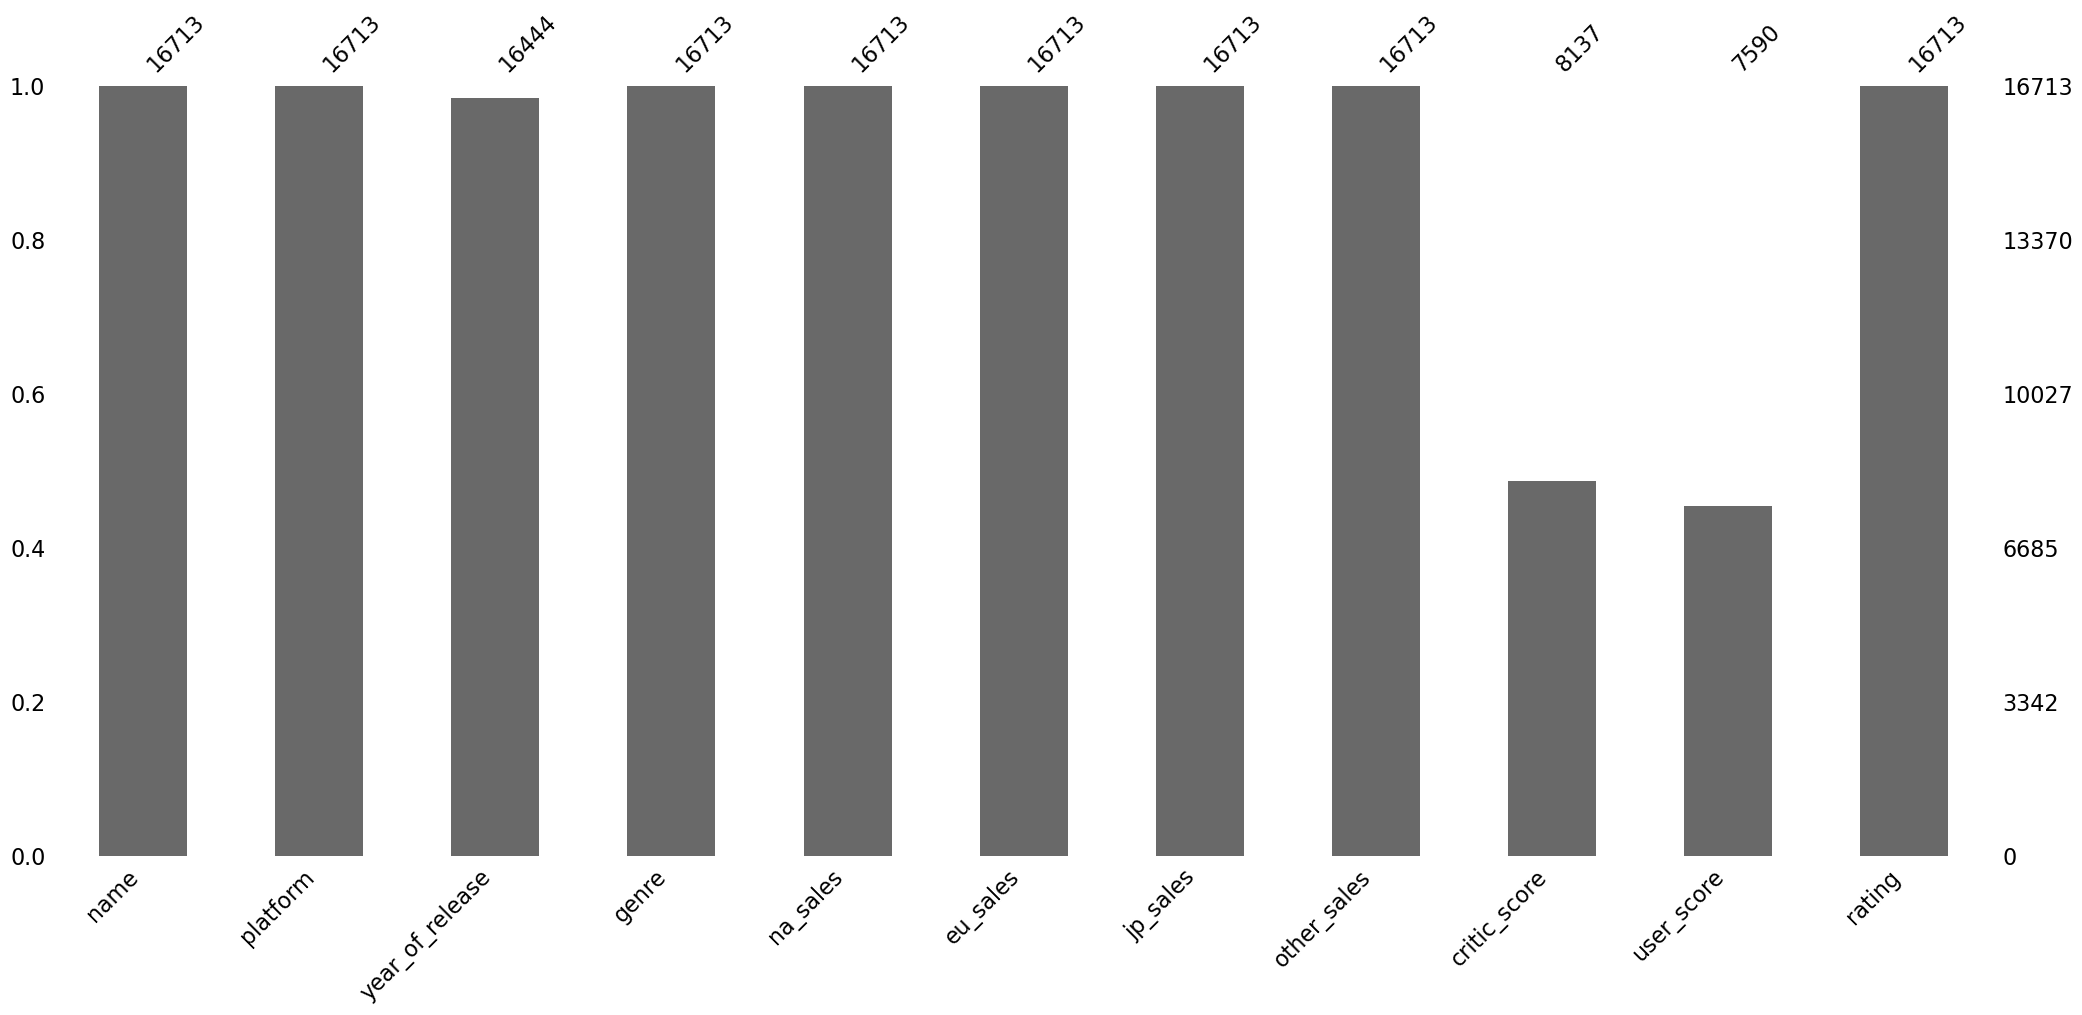

In [44]:
#повторная проверка значений
msno.bar(df);

### Суммарные продажи

In [45]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [46]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


## Исследовательский анализ данных

### Количество игр в разные годы

Text(0, 0.5, 'Количество')

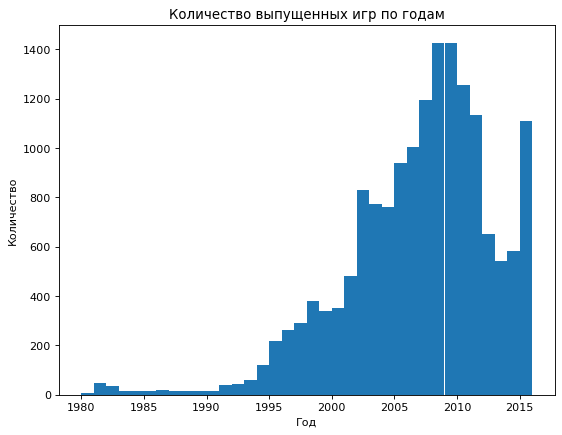

In [47]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год')

df['year_of_release'].plot(kind='hist', bins = 36);
plt.ylabel('Количество')

Гистограмма распределения выпущенных игр показывает, что масштабное производство началось только в середине 90-х годов. Пик значений пришелся на период 2008-2009 гг. Затем наметился спад, который можно объяснить появлением мобильных устройств. Наконец, в 2016 ситуация поменялась и игры вновь обрели популярность.

In [48]:
 df = df.query('year_of_release > 1994 or year_of_release.isnull()', engine='python')

### Продажи на разных платформах

Выберем платформы с наибольшими суммарными продажами и построим графики распределения по годам.

In [49]:
sales_per_platform_per_year = df.groupby('platform')['total_sales'].sum().sort_values(ascending=True)

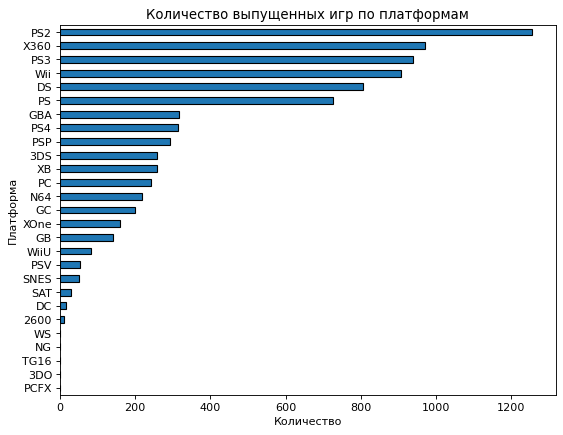

In [51]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Количество выпущенных игр по платформам')
plt.xlabel('Количество')

sales_per_platform_per_year.plot(kind='barh', ec='black');
plt.ylabel('Платформа');

В лидерах оказались **PS2** (с отрывом), **Xbox 360** и **PS3**. В конце списка малопопулярные японские консоли. Теперь посмотрим на график продаж игр по годам на каждой платформе. Для этого возьмем первые 6 позиций рейтинга, поскольку они заметно выделяются на общем фоне.

In [52]:
top_6_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
top_6_df = df.query('platform in @top_6_platforms')

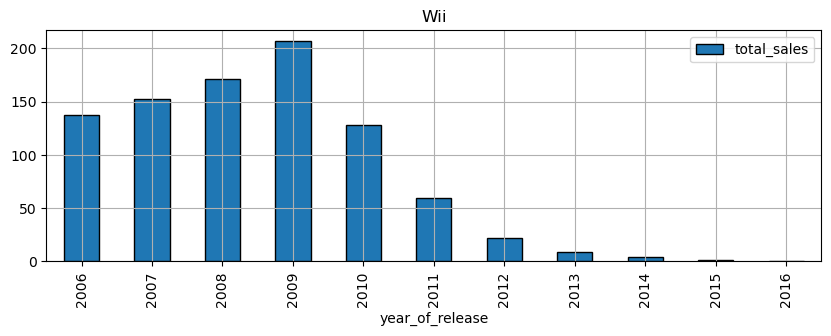

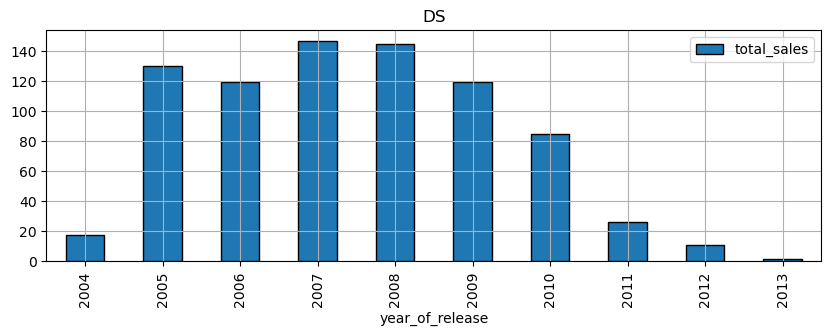

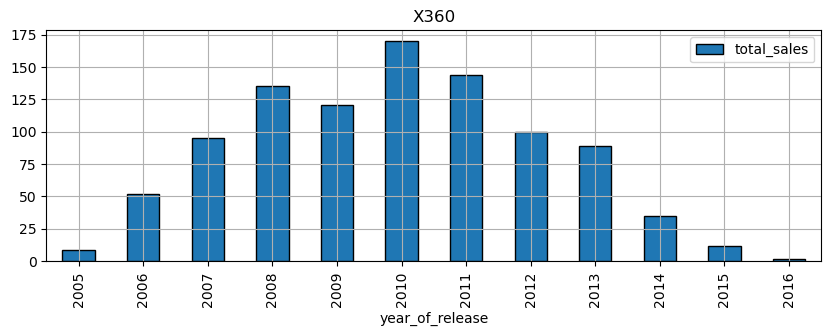

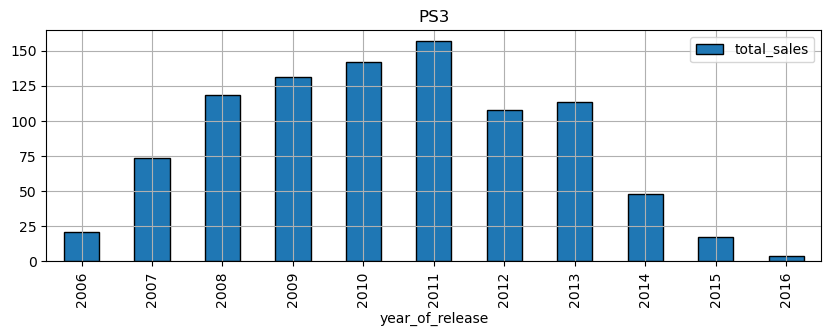

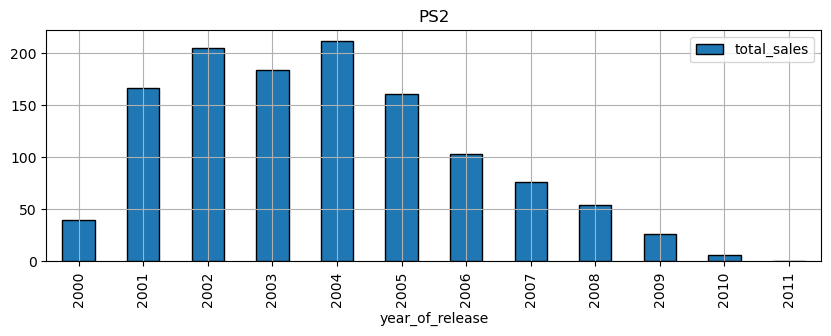

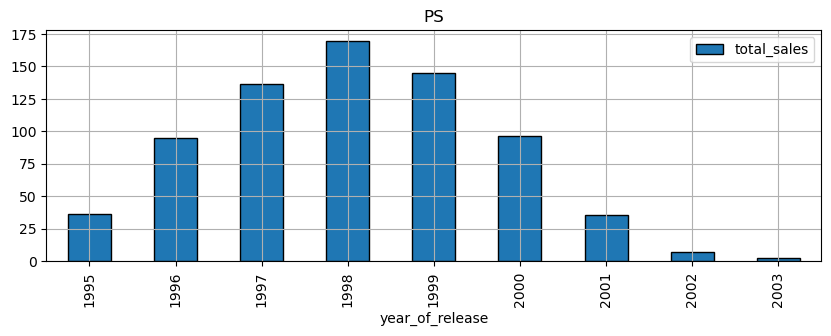

In [53]:
for i in top_6_df['platform'].unique():
    top_6_df.query('platform == @i').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 3), ec='black')
    plt.title(i)
    plt.show()

Мы получили графики распределения по годам, которые условно можно считать "продолжительностью жизни" платформы. Данные таковы:

* PS2 - 11 лет
* X360 - 11 лет
* PS3 - 10 лет
* Wii - 10 лет
* DS - 9 лет
* PS - 8 лет

Таким образом, мы можем считать, что +- 10 лет - это средний срок существования платформы.



### Актуальная ситуация с продажами игр на платформах

Индустрия игр - динамичная сфера. Как мы уже убедились на предыдущем шаге, слишком большой промежуток времени может захватить с собой частичку другой эпохи.

Ограничим наш датасет данными за последние 5 лет, с 2012 по 2016 гг.

In [54]:
df_recent_years = df.query('year_of_release >= 2012 or year_of_release.isnull()', engine='python')

Теперь визуализируем статистику по продажам с помощью метода heatmap из библиотеки seaborn.

In [55]:
df_recent_years_pivot = pd.pivot_table(df_recent_years, index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

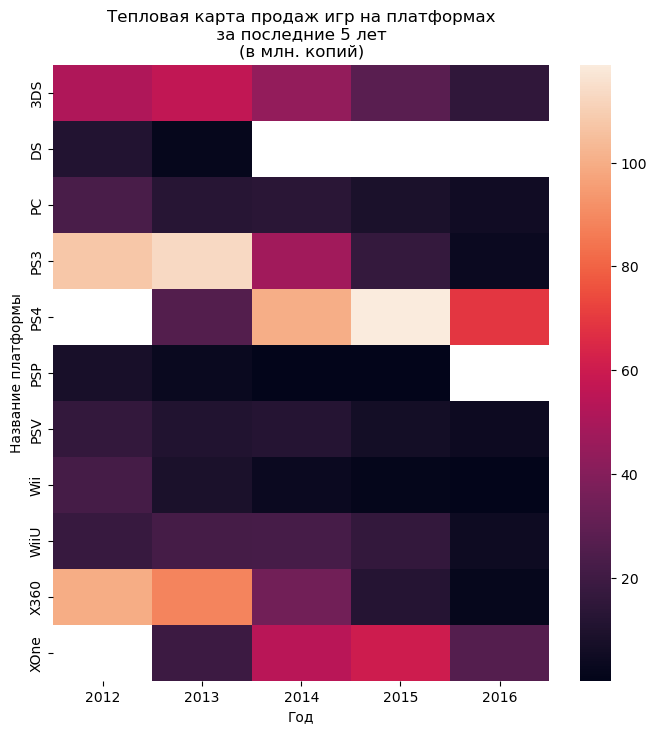

In [56]:
plt.figure(figsize=(8, 8))
plt.title('Тепловая карта продаж игр на платформах\n за последние 5 лет \n(в млн. копий)')
sns.heatmap(df_recent_years_pivot.T)
plt.xlabel('Год')
plt.ylabel('Название платформы');

Тепловая карта позволяет нам сделать следующие выводы:

* Количество проданных консольных игр за последние годы падает.
* Продажи **PS4** успели подняться до максимума в 2015 году, а затем предположительно уменьшились (мы не можем быть до конца уверенными, потому что наши данные неполны). В любом случае, **PS4** - это лидер по платформам на данный момент.
* Второй в гонке можно считать платформу **Xbox One**, которая за последние годы то набирает, то теряет в популярности.
* **DS** и **PSP** выбыли из игры в 2013 и 2015 годах соответственно.


### Глобальные продажи игр в разбивке по платформам

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

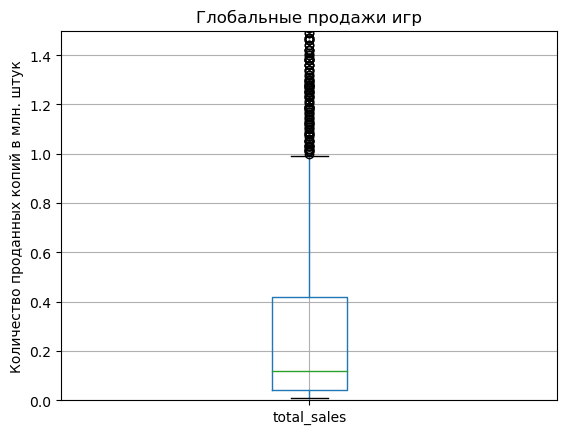

In [58]:
plt.figure()
ax = df_recent_years.boxplot(column='total_sales')
ax.set_title('Глобальные продажи игр')
ax.set(ylabel='Количество проданных копий в млн. штук')
ax.set_ylim([0, 1.5]);

В среднем одна игра продается количеством около 100 тысяч копий, хотя отдельные экземпляры могут продаваться и по 1 млн копий (верхний предел значений).

Теперь посмотрим на ситуацию под другим углом, сравнив глобальные продажи в привязке к самым популярным платформам.

In [59]:
df_query = df_recent_years.query('platform in @top_6_platforms')
by_column = 'platform in @top_6_platforms'.split()[0]
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

<Figure size 640x480 with 0 Axes>

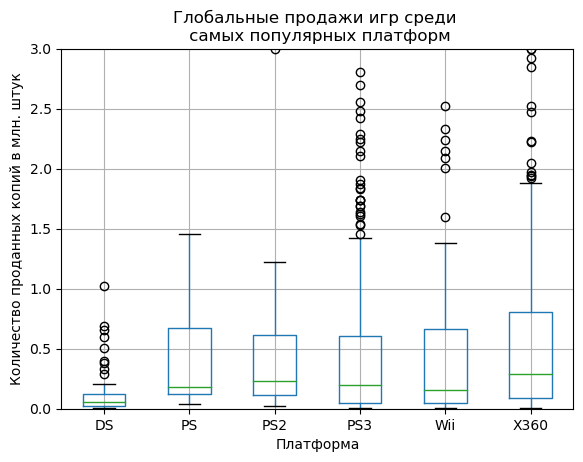

In [61]:
plt.figure()
ax = df_query.boxplot(column='total_sales', by=by_column);
plt.suptitle('')
ax.set_title('Глобальные продажи игр среди \n самых популярных платформ')
ax.set(ylabel='Количество проданных копий в млн. штук', xlabel='Платформа')
ax.set_ylim([0, 3]);

На графике видно, что:

* **Xbox 360** занимает самую привлекательную позицию, где игры в среднем продаются по 250 тыс. копий. Некоторые доходят до 2 млн. копий, хотя основная масса все же располагается в границах от 100 до 800 тыс. экземпляров.
* Ситуация с **PS**, **PS2**, **PS3** и **Wii** примерно одинаковая. Обе платформы обычно продают в районе 150-200 тыс. копий игры. Некоторые позиции доходят до 1.5 млн копий. У **PS3** особенно много выбросов, т.е. есть сверх-удачные проекты, но они скорее исключения.
* Наконец, платформа **DS** выглядит самым слабым игроком среди прочих. Даже успешные игры здесь не продаются количеством более 450 тыс. копий.

### Влияние отзывов пользователей и критиков на продажи

Обратимся к платформе Xbox 360 и проверим, как отзывы влияют на продажи.

In [62]:
x360_platform_sales = df_recent_years[df['platform'] == 'X360'].reset_index()

C:\Users\kosty\AppData\Local\Temp\ipykernel_33388\1494046519.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x360_platform_sales = df_recent_years[df['platform'] == 'X360'].reset_index()


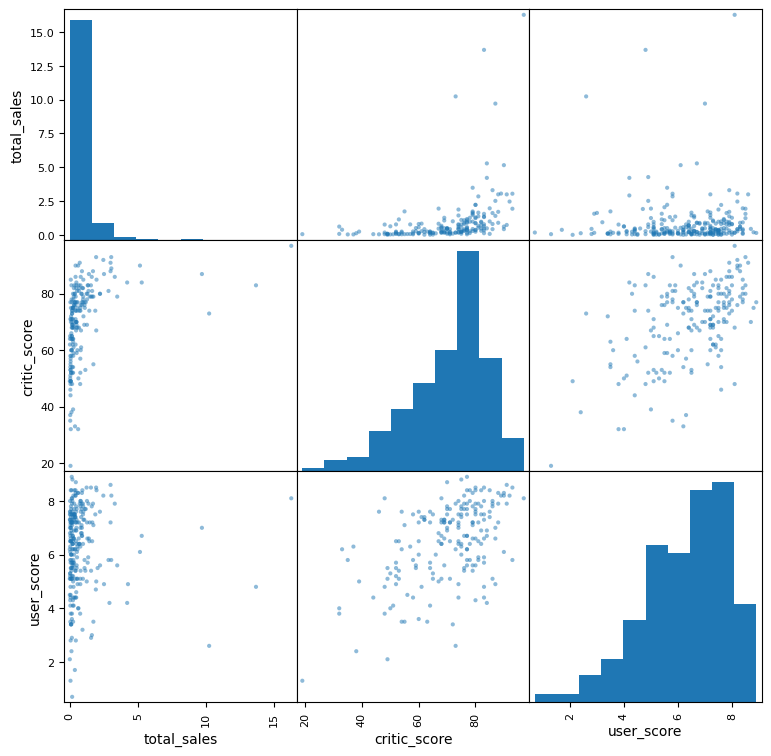

In [63]:
pd.plotting.scatter_matrix(x360_platform_sales[['total_sales', 'critic_score', 'user_score']], figsize=(9, 9), grid=True);

In [64]:
x360_platform_sales[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.368118,0.005917
critic_score,0.368118,1.000000,0.520840
user_score,0.005917,0.520840,1.000000


На основании диаграммы рассеяния и таблицы с корреляциями мы можем сделать следующие выводы (для Xbox 360):
* Корреляция между **отзывами экспертов** и продажами есть, но слабая.
* Корреляции между **отзывами пользователей** и продажами нет.
* Есть умеренная корреляция между оценками экспертов и пользователей (возможно, некоторые пользователи ориентируются на оценки экспертов)

### Соотнесение выводов с продажами на других платформах

Платформа Nintendo Wii
              total_sales  critic_score  user_score
total_sales      1.000000      0.355464    0.193916
critic_score     0.355464      1.000000    0.325125
user_score       0.193916      0.325125    1.000000


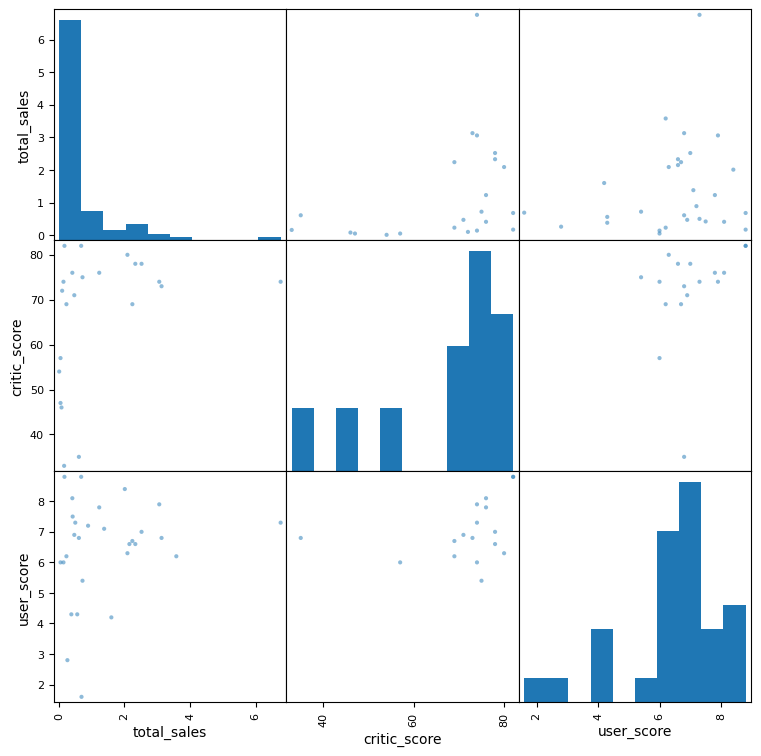

In [65]:
wii_platform_sales = df_recent_years.query('platform == "Wii"')[['total_sales', 'critic_score', 'user_score']]
print('Платформа Nintendo Wii')
pd.plotting.scatter_matrix(wii_platform_sales, figsize=(9, 9));
print(wii_platform_sales.corr())

Платформа Play Station 3
              total_sales  critic_score  user_score
total_sales      1.000000      0.331966   -0.006936
critic_score     0.331966      1.000000    0.534327
user_score      -0.006936      0.534327    1.000000


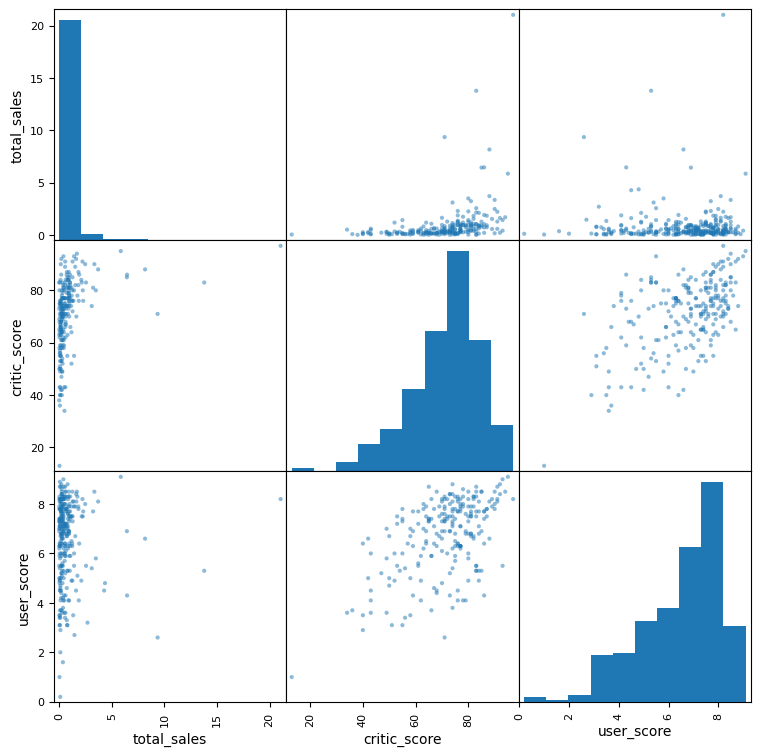

In [66]:
ps3_platform_sales = df_recent_years.query('platform == "PS3"')[['total_sales', 'critic_score', 'user_score']]
print('Платформа Play Station 3')
pd.plotting.scatter_matrix(ps3_platform_sales, figsize=(9, 9))
print(ps3_platform_sales.corr())

Платформа Xbox One
              total_sales  critic_score  user_score
total_sales      1.000000      0.416998   -0.068925
critic_score     0.416998      1.000000    0.472462
user_score      -0.068925      0.472462    1.000000


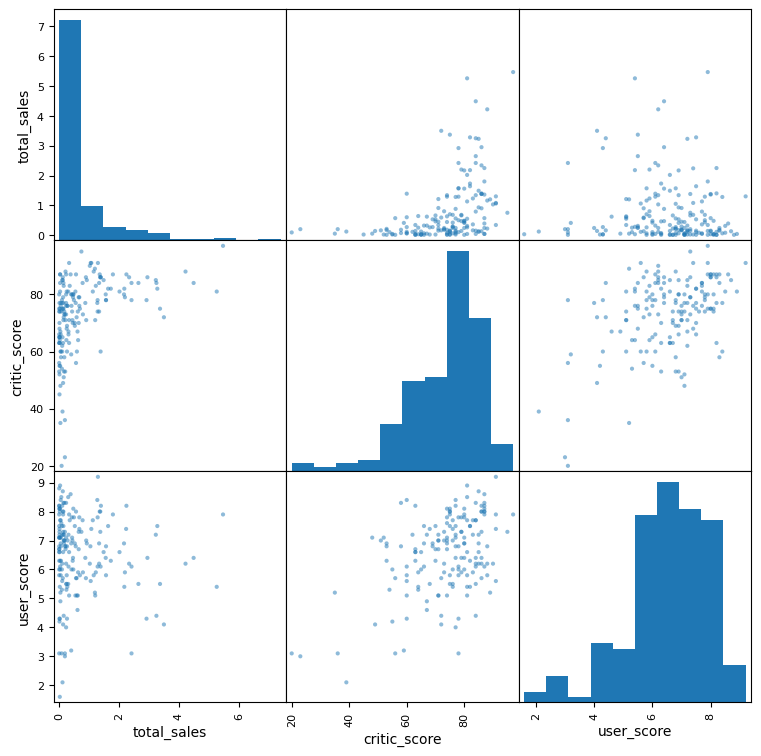

In [67]:
xone_platform_sales = df_recent_years.query('platform == "XOne"')[['total_sales', 'critic_score', 'user_score']]
print('Платформа Xbox One')
pd.plotting.scatter_matrix(xone_platform_sales, figsize=(9, 9))
print(xone_platform_sales.corr())

На основании сравнения **Xbox 360** и других платформ (**Wii**, **PS3**, **XOne**) можно сделать вывод, что ситуация в целом повторяется. Есть слабая корреляция между оценками критиков и продажами, а также отрицательная или нулевая корреляция между отзывами пользователей и продажами. Платформа Wii демонстрирует отсутствие корреляции даже в ситуация экспертной оценки.

### Общее распределение игр по жанрам

Сперва посмотрим на количество игр, выпущенных в каждом жанре.

In [68]:
games_per_genre = df_recent_years.groupby('genre')['name'].count().sort_values(ascending=True)

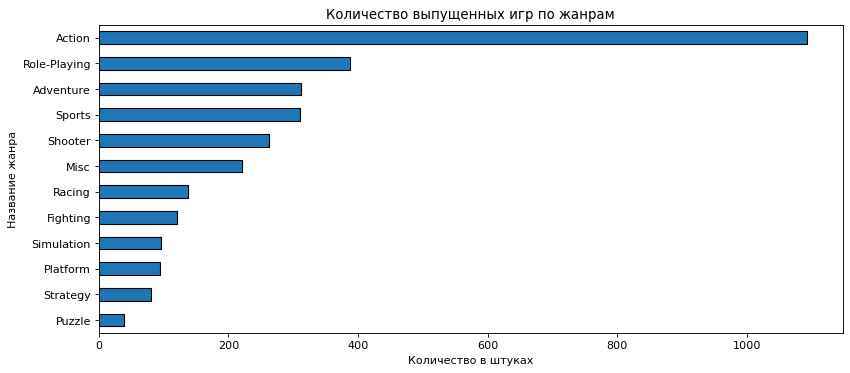

In [69]:
plt.figure(figsize=(12, 5), dpi=80)
plt.title('Количество выпущенных игр по жанрам')
plt.xlabel('Количество в штуках')

games_per_genre.plot(kind='barh', ec='black')
plt.ylabel('Название жанра');

Игры жанра **'Action'** уверенно лидируют в общем количестве, обгоняя своего ближайшего конкурента более чем в 2 раза. В датасете пазлов оказалось меньше всего.
Теперь посмотрим на статистику по продажам среди этих жанров.

In [70]:
sales_per_genre = df_recent_years.groupby('genre')['total_sales'].sum().sort_values(ascending=True)

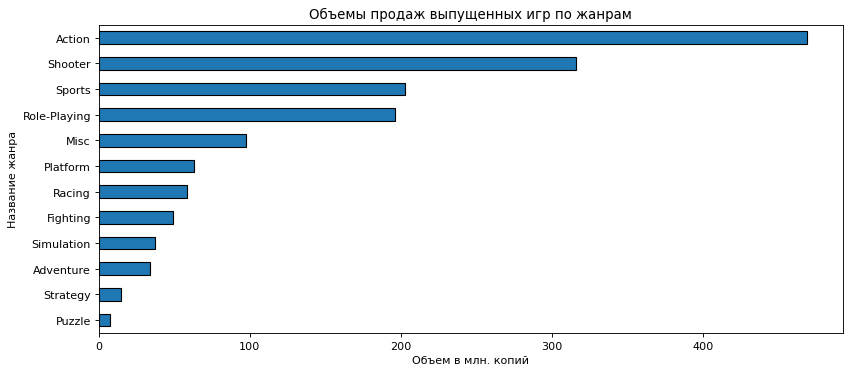

In [71]:
plt.figure(figsize=(12, 5), dpi=80)
plt.title('Объемы продаж выпущенных игр по жанрам')
plt.xlabel('Объем в млн. копий')

sales_per_genre.plot(kind='barh', ec='black')
plt.ylabel('Название жанра');

Здесь мы наблюдаем интересную ситуацию. Экшн-игры обгоняют не только разнообразием, но и своими продажами. Однако, отрыв от ближайшего конкурента не такой существенный. Шутеры в данном рейтинге занимают второе место, тогда как по количеству игр они были на пятом месте.

Посчитаем, сколько в среднем продаж приносит одна игра в каждом жанре.

In [76]:
genre_rating = (df_recent_years.groupby(['genre']).agg(total_sales_per_genre=('total_sales', 'sum'), \
                                                       count_games=('name', 'count'))
                                                  .sort_values(by='total_sales_per_genre', ascending=False))

In [73]:
genre_rating['sales_per_game'] = genre_rating['total_sales_per_genre'] * 1000000 / genre_rating['count_games']

In [74]:
genre_rating = genre_rating.sort_values(by='sales_per_game', ascending=True)

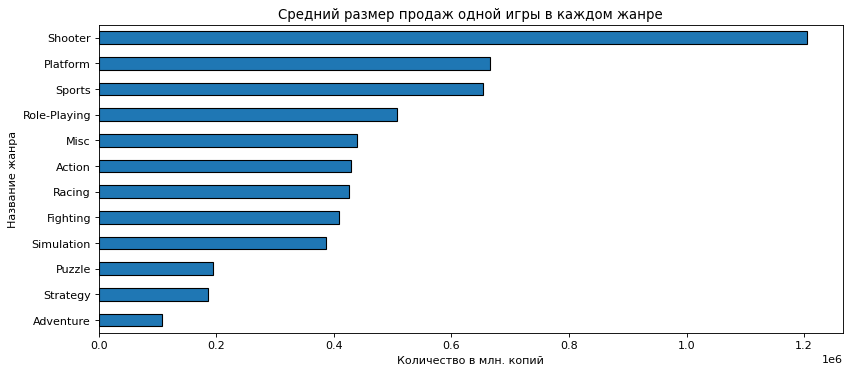

In [75]:
plt.figure(figsize=(12, 5), dpi=80)
plt.title('Средний размер продаж одной игры в каждом жанре')
plt.xlabel('Количество в млн. копий')

genre_rating['sales_per_game'].plot(kind='barh', ec='black')
plt.ylabel('Название жанра');

Итак, на основании изученных **общих продаж** мы можем сделать следующие вывыды:
* Во-первых, существуют жанры с высокими и низкими продажами.
* Жанры вроде экшена, шутеров и спортивных игр заметно популярнее стратегий, пазлов и приклюнческих игр.

Если смотреть на **продажи случайной конкретной игры**, то в среднем получается, что:
* Шутеры заметно обгоняют претендентов по количеству проданных копий, поэтому этот жанр самый прибыльный.
* Платформеры на втором месте. Вопреки стереотипам о "мультяшной графике" игры жанра уверенно обгоняют большую часть списка.
* Финалистом оказались приключенческие игры.

## Портрет пользователя каждого региона

In [77]:
sales_region = ['na_sales', 'eu_sales', 'jp_sales']
region_name = ['Северной Америки', 'Европы', 'Японии']

for i, k in zip(sales_region, region_name):
  print('Лидеры', k)
  print(df_recent_years.groupby(['platform']).agg({i:'sum'}).reset_index().sort_values(by=i, ascending=False).head(5))
  print()

Лидеры Северной Америки
   platform  na_sales
16     X360    146.78
11      PS4    108.74
10      PS3    106.74
18     XOne     93.12
1       3DS     56.15

Лидеры Европы
   platform  eu_sales
11      PS4    141.09
10      PS3    109.94
16     X360     76.96
18     XOne     51.59
1       3DS     42.85

Лидеры Японии
   platform  jp_sales
1       3DS     87.84
10      PS3     36.07
13      PSV     21.11
11      PS4     15.96
15     WiiU     13.01



### Северная Америка

Определим топ-5 популярных платформ для региона.

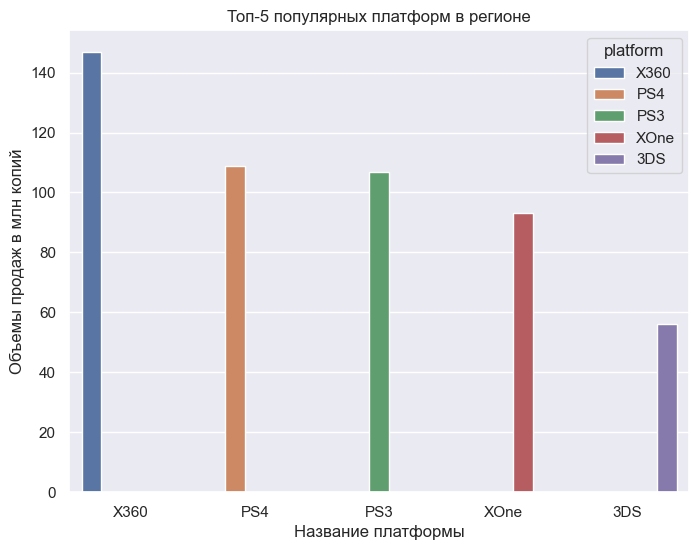

In [78]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='platform',
            y='na_sales',
            hue="platform",
            data=df_recent_years.groupby(['platform']).agg({'na_sales':'sum'}).reset_index().sort_values(by='na_sales', ascending=False).head(5),
)

ax.set_title('Топ-5 популярных платформ в регионе')
ax.set(xlabel='Название платформы', ylabel='Объемы продаж в млн копий');

Xbox 360 выигрывает гонку у своих ближайших конкурентов от Sony. Это необычное обстоятельство, ведь платформе уже много лет (дата выхода 2005 г). PS4 выступает как более современный конкурент, но все ещё проигрывает в долях на рынке.

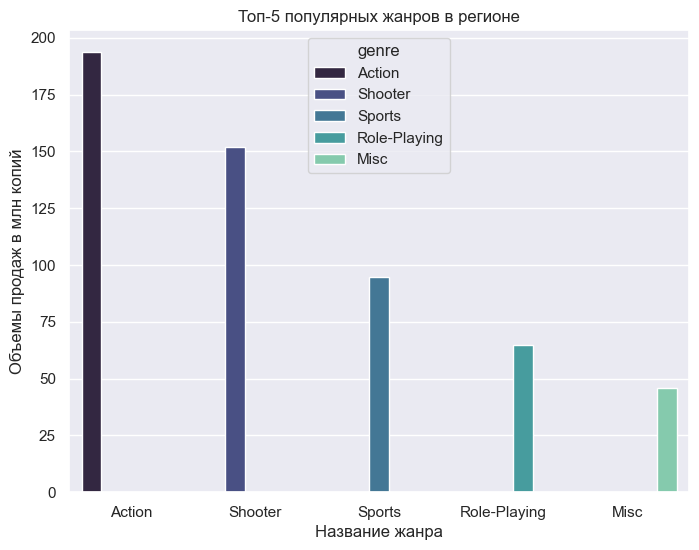

In [79]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='genre',
            y='na_sales',
            hue="genre",
            data=df_recent_years.groupby(['genre']).agg({'na_sales':'sum'}).reset_index().sort_values(by='na_sales', ascending=False).head(5),
            palette="mako"
)

ax.set_title('Топ-5 популярных жанров в регионе')
ax.set(xlabel='Название жанра', ylabel='Объемы продаж в млн копий');

Здесь нет каких-либо неожиданных данных. Тройка лидеров соответствует глобальной.

Теперь определим влияние **ESRB рейтинга** на продажи в регионе.

Пояснение к категориям рейтинга:
1. «EC» («Early childhood») — «Для детей младшего возраста»
2. «E» («Everyone») — «Для всех»
3. «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
4. «T» («Teen») — «Подросткам»
5. «M» («Mature») — «Для взрослых»
6. «AO» («Adults Only 18+») — «Только для взрослых»
7. «RP» («Rating Pending») — «Рейтинг ожидается
8. "K-A" («For Kids to Adults») - «Для всех». Устаревшая категория. В нашей выборке она отсутствует.

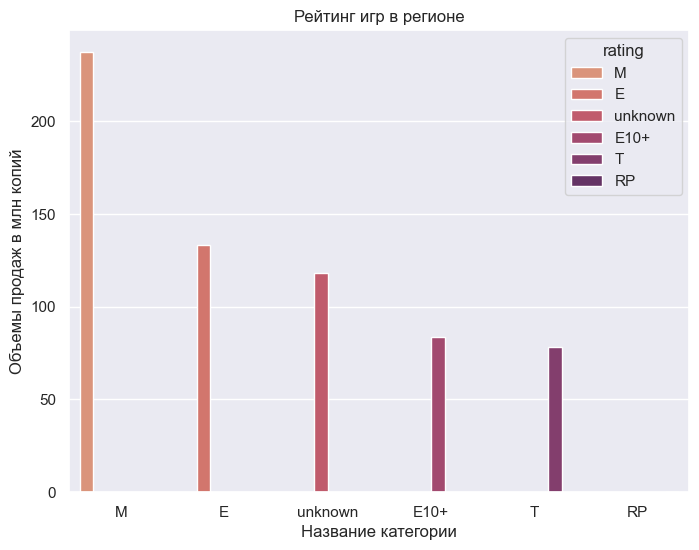

In [80]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='rating',
            y='na_sales',
            hue="rating",
            data=df_recent_years.groupby(['rating']).agg({'na_sales':'sum'}).reset_index().sort_values(by='na_sales', ascending=False),
            palette="flare"
)

ax.set_title('Рейтинг игр в регионе')
ax.set(xlabel='Название категории', ylabel='Объемы продаж в млн копий');

Итак, определим портрет условного пользователя из региона Северная Америка:
* Платформа: Xbox 360
* Жанр игры: Action
* Рейтинг игры: M (для взрослых)

### Европа

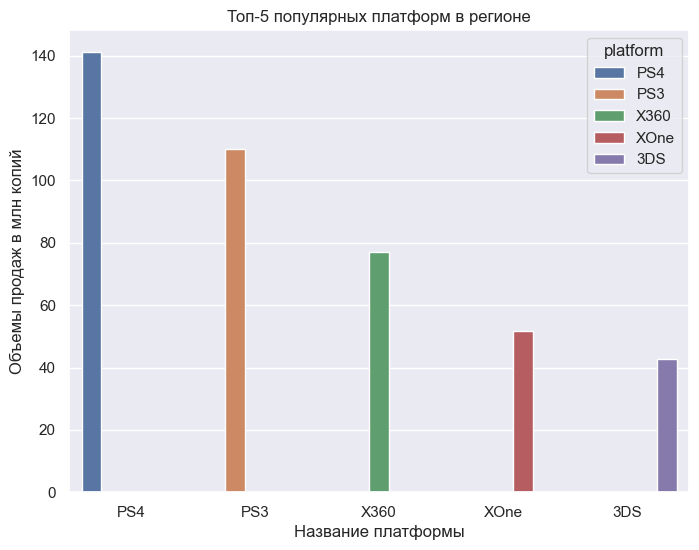

In [81]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='platform',
            y='eu_sales',
            hue="platform",
            data=df_recent_years.groupby(['platform']).agg({'eu_sales':'sum'}).reset_index().sort_values(by='eu_sales', ascending=False).head(5),
)

ax.set_title('Топ-5 популярных платформ в регионе')
ax.set(xlabel='Название платформы', ylabel='Объемы продаж в млн копий');

В отличие от Северной Америки, в Европе самой популярной платформой является новая **PS4**. Затем следует её предшественница, а **Xbox 360** на третьем месте. Сложно объяснить это различие. Возможно, жители Америки уже давно купили себе приставку и стараются использовать её до конца, тогда как европейцы только приобщаются к платформам, поэтому покупают актуальные модели.

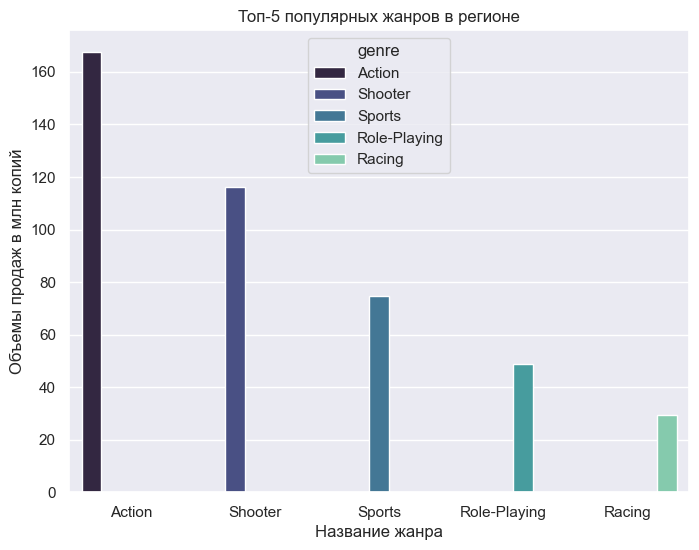

In [82]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='genre',
            y='eu_sales',
            hue="genre",
            data=df_recent_years.groupby(['genre']).agg({'eu_sales':'sum'}).reset_index().sort_values(by='eu_sales', ascending=False).head(5),
            palette="mako"
)

ax.set_title('Топ-5 популярных жанров в регионе')
ax.set(xlabel='Название жанра', ylabel='Объемы продаж в млн копий');

Здесь всё без особых измений. На пятом месте появляются гонки.

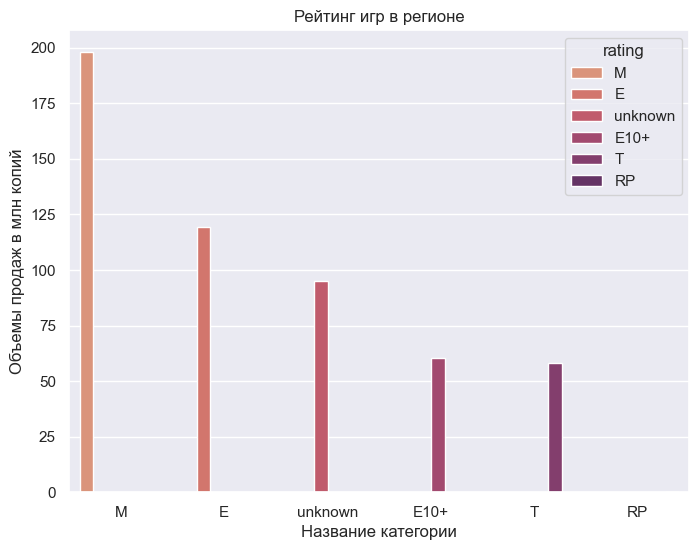

In [83]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='rating',
            y='eu_sales',
            hue="rating",
            data=df_recent_years.groupby(['rating']).agg({'eu_sales':'sum'}).reset_index().sort_values(by='eu_sales', ascending=False),
            palette="flare"
)

ax.set_title('Рейтинг игр в регионе')
ax.set(xlabel='Название категории', ylabel='Объемы продаж в млн копий');

Таким образом, портрет среднего пользователя из региона Европа выглядит следующим образом:
* Платформа: PS4
* Жанр игры: Action
* Рейтинг игры: M (для взрослых)

### Япония

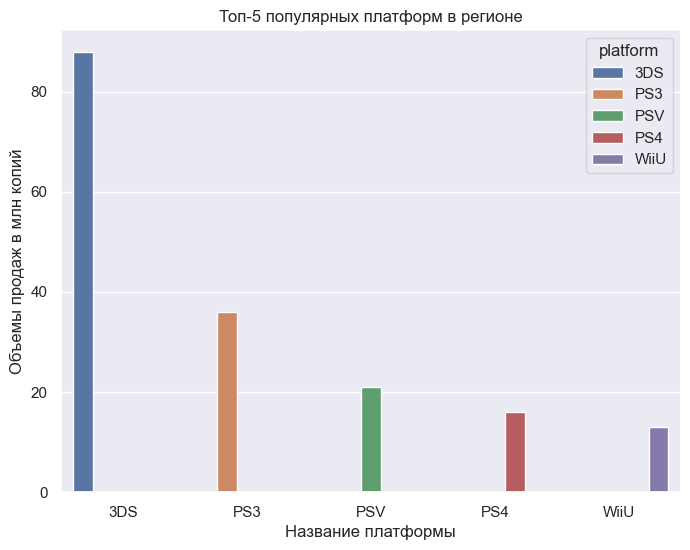

In [84]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='platform',
            y='jp_sales',
            hue="platform",
            data=df_recent_years.groupby(['platform']).agg({'jp_sales':'sum'}).reset_index().sort_values(by='jp_sales', ascending=False).head(5),
)

ax.set_title('Топ-5 популярных платформ в регионе')
ax.set(xlabel='Название платформы', ylabel='Объемы продаж в млн копий');

Отличие Японии от других регионов чувствуется сразу. Вместо стационарных устройств здесь мы видим сразу 2 портативных: лидер списка, японский девайс Nintendo 3DS, а также 3-й кандидат - Play Station Vita. В целом, мы фиксируем интерес японцев к недорогим мобильным игровым консолям.

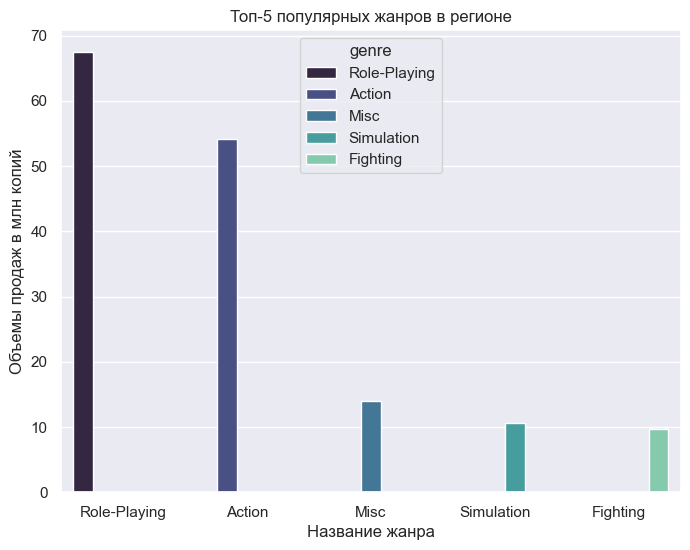

In [85]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='genre',
            y='jp_sales',
            hue="genre",
            data=df_recent_years.groupby(['genre']).agg({'jp_sales':'sum'}).reset_index().sort_values(by='jp_sales', ascending=False).head(5),
            palette="mako"
)

ax.set_title('Топ-5 популярных жанров в регионе')
ax.set(xlabel='Название жанра', ylabel='Объемы продаж в млн копий');

Отличаются и жанры игр. В Японии экшн уступает первенство ролевым играм. Также на сцену выходят симуляторы и файтинги. Шутеры, спортивные игры и гонки здесь не пользуются особой популярностью.

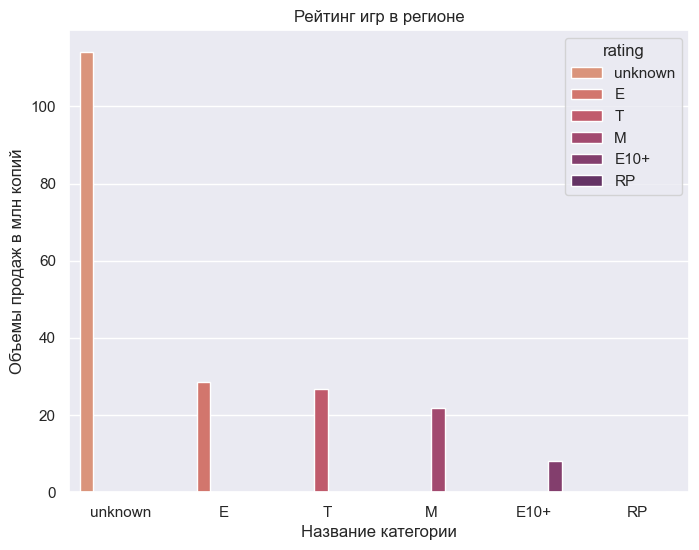

In [86]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='rating',
            y='jp_sales',
            hue="rating",
            data=df_recent_years.groupby(['rating']).agg({'jp_sales':'sum'}).reset_index().sort_values(by='jp_sales', ascending=False),
            palette="flare"
)

ax.set_title('Рейтинг игр в регионе')
ax.set(xlabel='Название категории', ylabel='Объемы продаж в млн копий');

В случае с рейтингом ситуация также особая. Мы видим большое количество игр без рейтинга. Это может быть связано с тем, что производители просто не озадачивают себя данным требованием, потому что законодательство и общественное настроение  не воспрещает этого. Это может быть форма экономии бюджета. Либо же производители намеренно скрывают рейтинг. В целом, мы видим, что игр для взрослых здесь значительно меньше, чем в других регионах, но это лишь официально зарегистрированные издания. Как обстоят дела на самом деле сейчас сказать трудно.

В результате получаем портрет среднего пользователя из Японии:
* Платформа: 3DS
* Жанр игры: Role-Playing
* Рейтинг игры: Unknown (неизвестно)

### Общий вывод по главе

* Мы сравнили портреты пользователей в трех регионах (Северная Америка, Европа и Япония). Мы пришли к выводу, что первые два региона во многом похожи между собой. Япония же заметно отличается по всем параметрам. Это можно объяснить культурными, историческими и прочими факторами.
* Судя по объемам продаж рейтинг ESRB не влияет на рынок в регионе. Однако, ситуация с Японией такова, что там слишком много игр без рейтинга. Это осложняет однозначный ответ на вопрос.



## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Мы хотим сопоставить средние двух генеральных независимых совокупностей. Мы не уверены, что их дисперсии равны, поэтому `equal_var` сделаем `False`.

Нулевая гипотеза такова:
* Средние пользовательские рейтинги платформ Xbox One и PC не равны.

Альтернативная гипотеза:
* Средние пользовательские рейтинги платформ Xbox One и PC равны.

In [87]:
# в датасете оставались пропуски, которые сейчас необходимо удалить для корректной работы метода st.ttest_ind()
df_recent_years = df_recent_years.dropna()

In [88]:
xbox_one_score = df_recent_years.loc[df_recent_years['platform']=='XOne']['user_score']
pc_score = df_recent_years.loc[df_recent_years['platform']=='PC']['user_score']

In [89]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    xbox_one_score,
    pc_score,
    equal_var = False
)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

0.5926561176517491
Не отвергаем нулевую гипотезу


Итак, данные нашей первончальной гипотезе не противоречат. Шанс получить неравное среднее относительно высокий. Иными словами, оценки различаются и тому есть причина: эти устройства непохожи по множеству параметров. В свою очередь логично было бы предположить, что оценки Xbox One и PS4 будут скорее на одном уровне - две указанные платформы напрямую конкурируют за пользователей, представляют схожие сегменты рынка.

### Средние пользовательские рейтинги жанров Action и Sports разные

Мы хотим сопоставить средние двух генеральных независимых совокупностей. Здесь ситуация обратная первой гипотезе, поэтому мы изменяем наши условия. Мы не уверены, что их дисперсии равны, поэтому `equal_var` сделаем `False`.

Нулевая гипотеза такова:
* Средние пользовательские рейтинги жанров Action и Sport равны.

Альтернативная гипотеза:
* Средние пользовательские рейтинги жанров Action и Sport не равны.

In [90]:
action_genre_score = df_recent_years.loc[df_recent_years['genre']=='Action']['user_score']
sports_genre_score = df_recent_years.loc[df_recent_years['genre']=='Sports']['user_score']

In [91]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    action_genre_score,
    sports_genre_score,
    equal_var = False
)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

5.858072645452818e-14
Отвергаем нулевую гипотезу


Итак, данные говорят о том, что вероятность совпадения средних рейтингов у двух указанных жанров крайне мала. Данный результат, как кажется, сооветствует здравому смыслу. Обе совокупности никак не пересекаются между собой (вероятно, ни игроками, ни тематикой), поэтому напросно было бы ожидать совпадения пользовательских оценок.

## Общий вывод

Мы провели обширное исследование игровых закономерностей и пришли к следующим выводам.

 * История игровой индустрии знает взлеты и падения. Она трансформируется в ответ на запросы времени и пользователей. Так, в середине 1990-х начался игровой бум, который достиг апогея в конце 2000-х годов, а затем снова пошел на спад. Сейчас индустрия реагирует на возросшее количество мобильных устройств и платформ, поэтому **общее количество выпускаемых игр уменьшается**. Возможно, это также связано со стомостью производства игр, но здесь нам не хватает данных.

 * **Средний срок жизни платформы** - около 10 лет. Это слишком большой горизонт, чтобы осуществлять какие-либо прогнозы. Для анализа нам необходимо дополнительно сокращать его, чтобы оставаться "на гребне волны" настоящего.

 * **Лидерами по количеству выпущенных игр остаются платформы-ветераны**: PS2 (с отрывом), Xbox 360 и PS3. Это во многом объясняется тем, что они были актуальны на протяжении долгого времени. Не только со стороны производителей, но и главным образом со стороны пользователей.

 * С точки зрения производителя игр стоить обратить внимание на Xbox 360, которая уверенно держит средний уровень продаж на отметке в 250 тыс. копий, тогда как другие не всегда доходят до 100 тыс.

 * Между оценками критиков/пользователей и продажами нет или почти нет корреляции. Но на слова критиков все же стоит обращать внимание, потому что они могут определять позиции многих других людей.

 * Игры жанра 'Action' превалируют в общем количестве, затем идут ролевые и приключенские игры. Стоит сказать, что это очень насыщенный рынок, где конкуренция будет самой серьезной.

 * Можно выделить **жанры с высокими и низкими продажами**: шутеры заметно обгоняют претендентов по количеству проданных копий одной игры, похожая ситуация с платформерами (популярны на мобильных устройствах) и спортивными играми. Экшн-игры далеко не на первом месте в этом отношении.


Наконец, стоит обратить внимание на **портрет пользователей** из разных регионов.

**Северная Америка** \
Платформа: Xbox 360 \
Жанр игры: Action \
Рейтинг игры: M (для взрослых) \

**Европа** \
Платформа: PS4 \
Жанр игры: Action \
Рейтинг игры: M (для взрослых) \

**Япония** \
Платформа: 3DS \
Жанр игры: Role-Playing \
Рейтинг игры: Unknown (неизвестно) \

Япония заметно отличается от других регионов, хотя и находилась долгое время под влиянием США. Разница между Северной Америкой и Европой, с другой стороны, не такая существенная. Японцы предпочитают мобильные (недорогие)
устройства, а также модели старшего поколения. Европейцы в большом количестве покупают игры для PS4, что говорит о высоком уровне достатка и о том, что это молодной рынок. В Северной Америке старых устройств куда больше, поэтому и игры для них все ещё пользуются популярностью.